In [1]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, f_oneway, levene
from statsmodels.stats.oneway import anova_oneway
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


In [2]:
# development_dataframe = pd.read_csv("/kaggle/input/health-insurance-cross-sell-prediction/train.csv")

development_dataframe = pd.read_csv("./input/train.csv")

# EDA

In [3]:
development_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [4]:
development_dataframe.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
train_df, val_df = train_test_split(development_dataframe, test_size=0.2, random_state=42, stratify=development_dataframe["Response"])

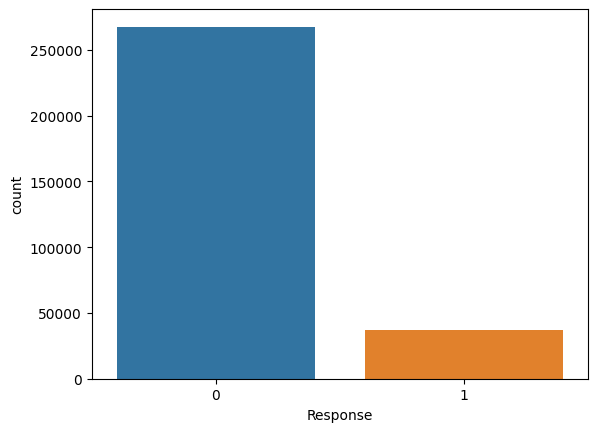

In [6]:
sns.countplot(x="Response", data=train_df)
plt.show()

### Does the gender impact on the upseling?

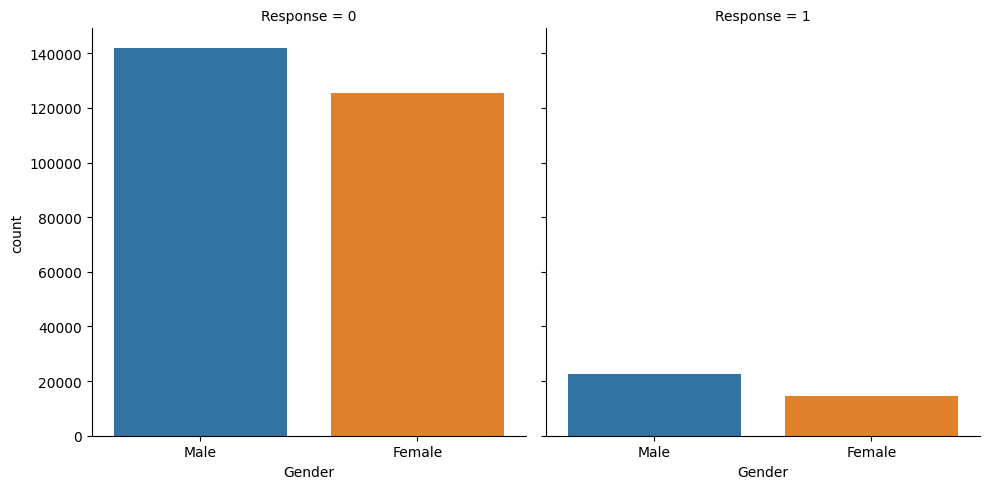

In [7]:
sns.catplot(x="Gender", col="Response", data=train_df, kind="count")
plt.show()

In [8]:
def test_categorical_independece(variables, response, data, alpha=0.05, correction=False):
    dependet_variables = data[variables]
    response_data = data[response]

    insurance_response_contigency_table = pd.crosstab(dependet_variables, response_data)

    _, p_value, _, _ = chi2_contingency(insurance_response_contigency_table, correction)

    if p_value <= alpha:
        print(f"p_value of {p_value}, distributions are dependent")
    else:
        print(f"p_value of {p_value}, distributions independent")

In [9]:
test_categorical_independece(variables="Gender", response="Response", data=train_df)

p_value of 2.376263829832788e-176, distributions are dependent


### Insurance predicts upseling?

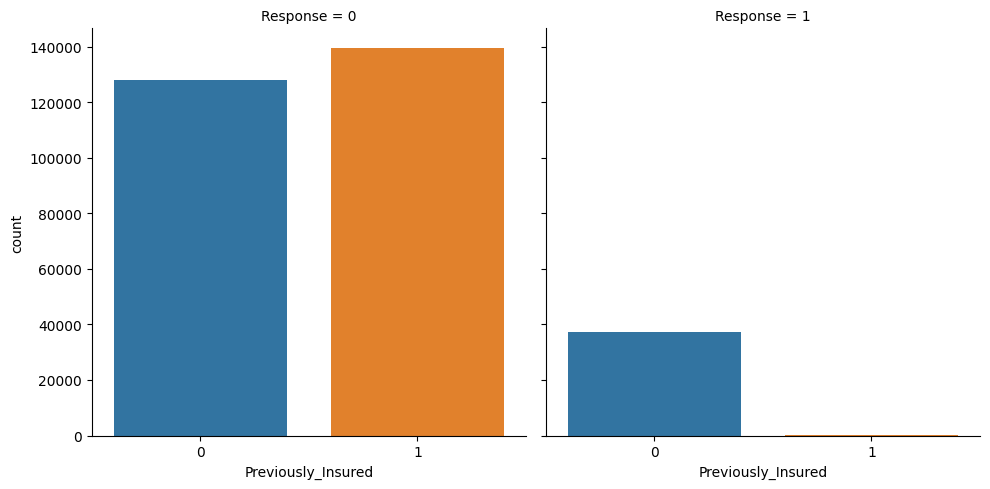

In [10]:
sns.catplot(x="Previously_Insured", col="Response", data=train_df, kind="count")
plt.show()

In [11]:
test_categorical_independece(variables="Previously_Insured", response="Response", data=train_df)

p_value of 0.0, distributions are dependent


### Impact of vehicle age

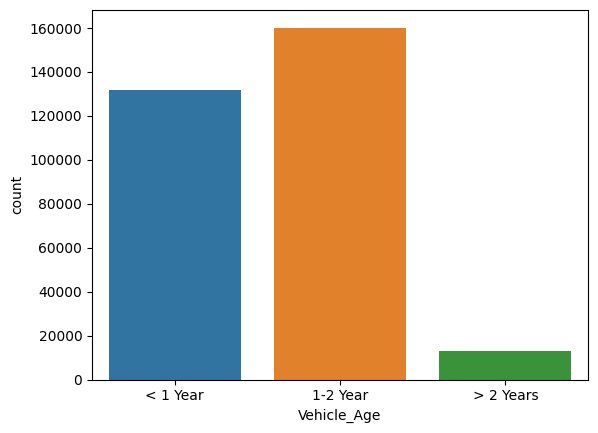

In [12]:
sns.countplot(x="Vehicle_Age", data=train_df)
plt.show()

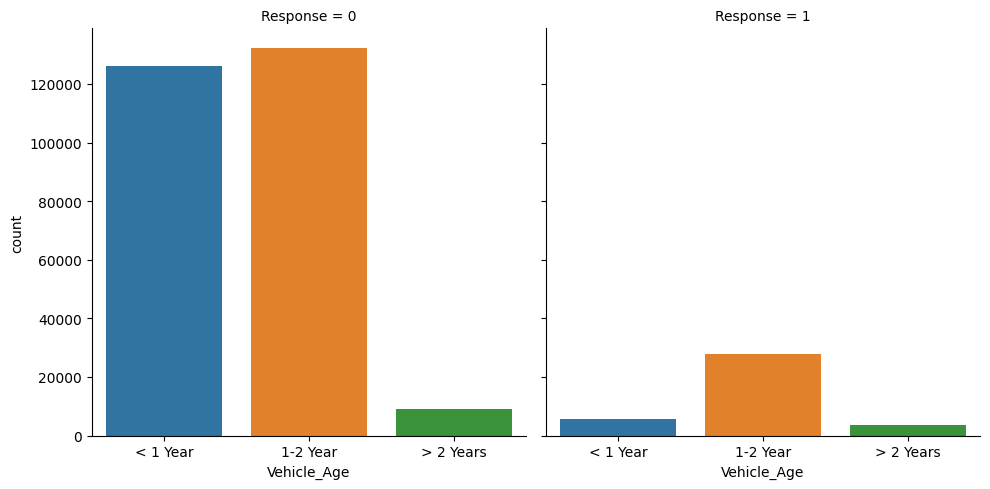

In [13]:
sns.catplot(x="Vehicle_Age", col="Response", data=train_df, kind="count")
plt.show()

In [14]:
test_categorical_independece(variables="Vehicle_Age", response="Response", data=train_df)

p_value of 0.0, distributions are dependent


### Impact of vehicle damage on upseling

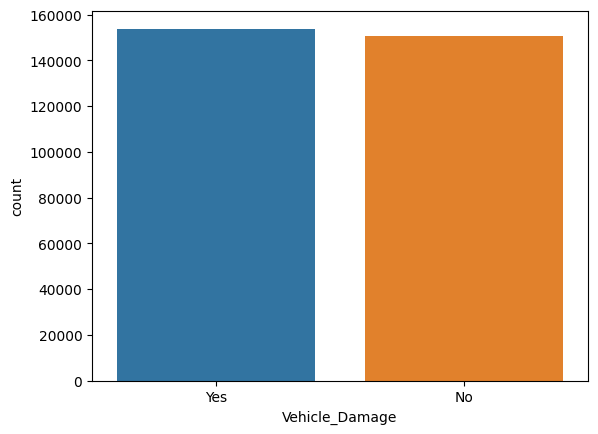

In [15]:
sns.countplot(x="Vehicle_Damage", data=train_df)
plt.show()

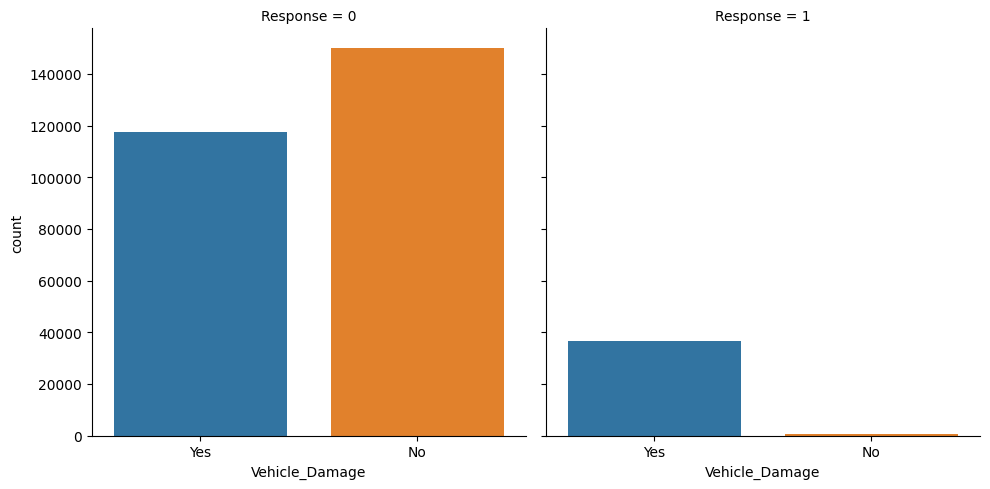

In [16]:
sns.catplot(x="Vehicle_Damage", col="Response", data=train_df, kind="count")
plt.show()

In [17]:
test_categorical_independece(variables="Vehicle_Damage", response="Response", data=train_df)

p_value of 0.0, distributions are dependent


### Driving license

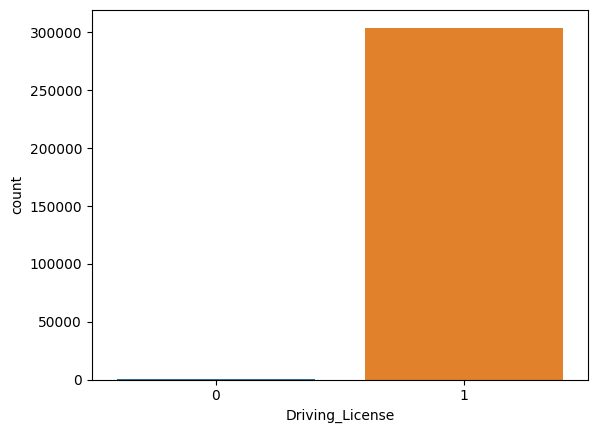

1    0.997855
0    0.002145
Name: Driving_License, dtype: float64

In [18]:
sns.countplot(x="Driving_License", data=train_df)
plt.show()

train_df["Driving_License"].value_counts(normalize=True)

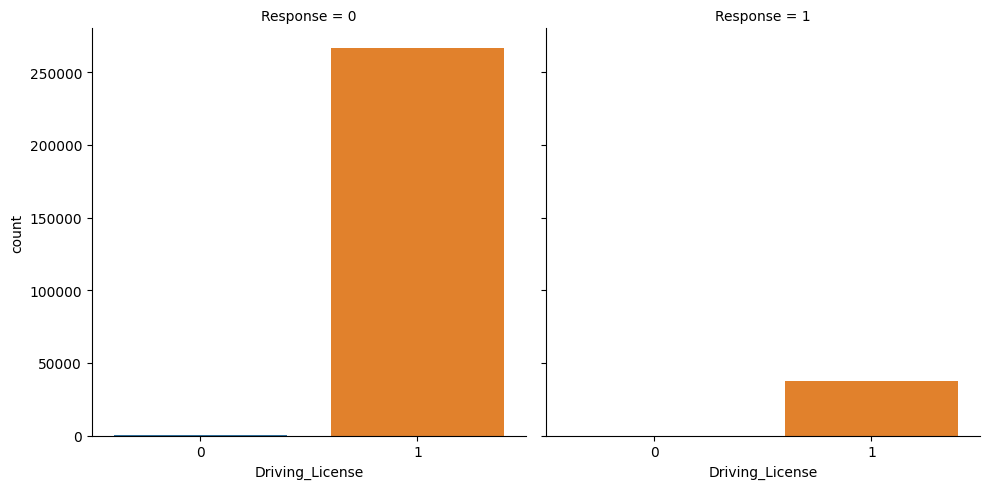

In [19]:
sns.catplot(x="Driving_License", col="Response", data=train_df, kind="count")
plt.show()

In [20]:
train_df.groupby("Response")["Driving_License"].value_counts(normalize=True)

Response  Driving_License
0         1                  0.997682
          0                  0.002318
1         1                  0.999090
          0                  0.000910
Name: Driving_License, dtype: float64

In [21]:
test_categorical_independece(variables="Driving_License", response="Response", data=train_df)

p_value of 3.596034970771421e-08, distributions are dependent


### Check if premium impacts on upseling

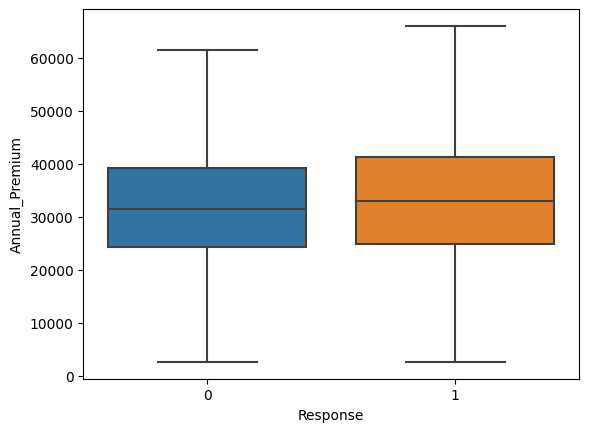

In [22]:
sns.boxplot(x="Response", y="Annual_Premium", showfliers=False, data=train_df)
plt.show()

In [23]:
train_df.groupby("Response")["Annual_Premium"].mean()

Response
0    30447.711157
1    31619.326054
Name: Annual_Premium, dtype: float64

In [24]:
no_cross_sell_premium = train_df.query("Response==0")["Annual_Premium"]
cross_sell_premium = train_df.query("Response==1")["Annual_Premium"]

_, p_value = ttest_ind(no_cross_sell_premium, cross_sell_premium, equal_var=False, random_state=42, permutations=100)

alpha = 0.05

if p_value < alpha:
    print(f"p_value of {p_value}, distributions don't have equal means")
else:
    print(f"p_value of {p_value}, can't say if distributions have different means")

p_value of 0.0, distributions don't have equal means


### Age impact

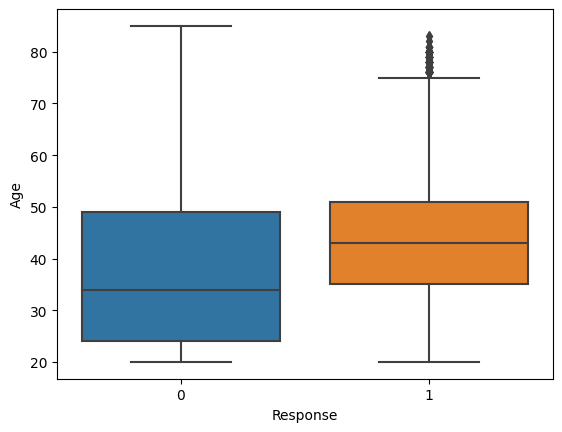

In [25]:
sns.boxplot(x="Response", y="Age", data=train_df)
plt.show()

In [26]:
no_cross_sell_age= train_df.query("Response==0")["Age"]
cross_sell_age = train_df.query("Response==1")["Age"]

_, p_value = ttest_ind(no_cross_sell_age, cross_sell_age, equal_var=False, random_state=42, permutations=100)

alpha = 0.05

if p_value < alpha:
    print(f"p_value of {p_value}, distributions don't have equal means")
else:
    print(f"p_value of {p_value}, can't say if distributions have different means")

p_value of 0.0, distributions don't have equal means


### Policy sales channel

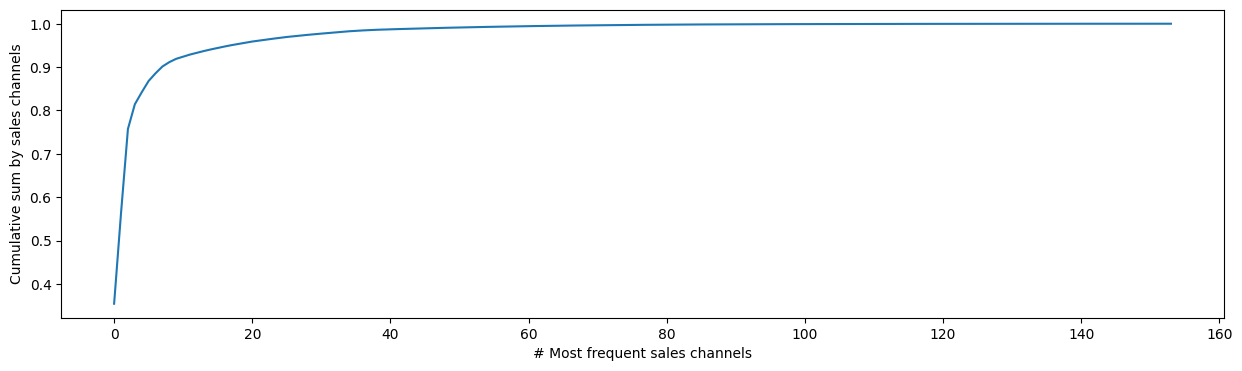

In [27]:
frequency_sales_channels = train_df["Policy_Sales_Channel"].value_counts(normalize=True)

cumulative_frequency_sales_channels = np.cumsum(frequency_sales_channels)
index = np.arange(len(frequency_sales_channels))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=cumulative_frequency_sales_channels, ax=ax)

ax.set_xlabel("# Most frequent sales channels")
ax.set_ylabel("Cumulative sum by sales channels")

plt.show()

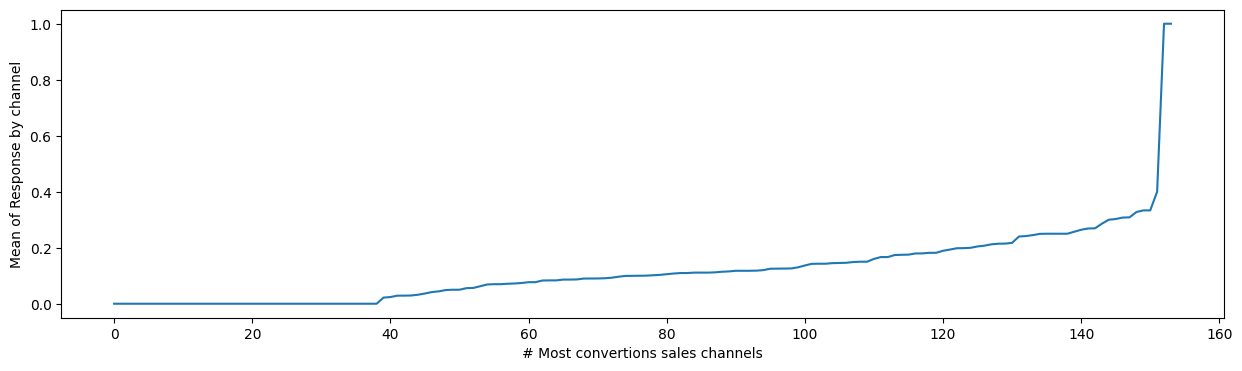

In [28]:
mean_response_by_sales_channel = train_df.groupby("Policy_Sales_Channel")["Response"].mean().sort_values()

mean_response_by_sales_channel.name="mean_response_by_sales_channel"

mean_response_by_sales_channel_values = mean_response_by_sales_channel.values
index = np.arange(len(mean_response_by_sales_channel))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=mean_response_by_sales_channel_values, ax=ax)

ax.set_xlabel("# Most convertions sales channels")
ax.set_ylabel("Mean of Response by channel")

plt.show()

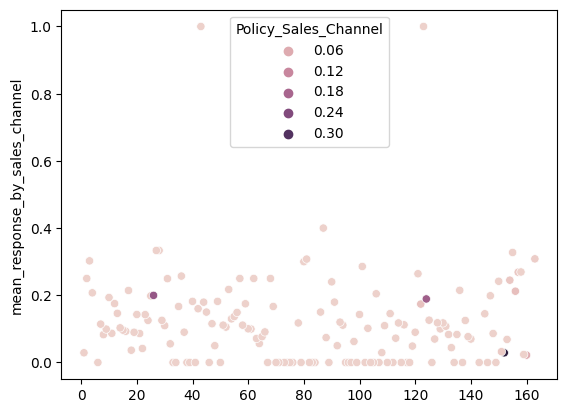

In [29]:
mean_response_and_frequency_by_sales_channel = pd.merge(mean_response_by_sales_channel, frequency_sales_channels, left_index=True, right_index=True)

sns.scatterplot(x=mean_response_and_frequency_by_sales_channel.index, y="mean_response_by_sales_channel", hue="Policy_Sales_Channel", data=mean_response_and_frequency_by_sales_channel)

plt.show()

In [30]:
most_frequent_sales_channels = cumulative_frequency_sales_channels[cumulative_frequency_sales_channels < 0.9].index

### Analyse vintage

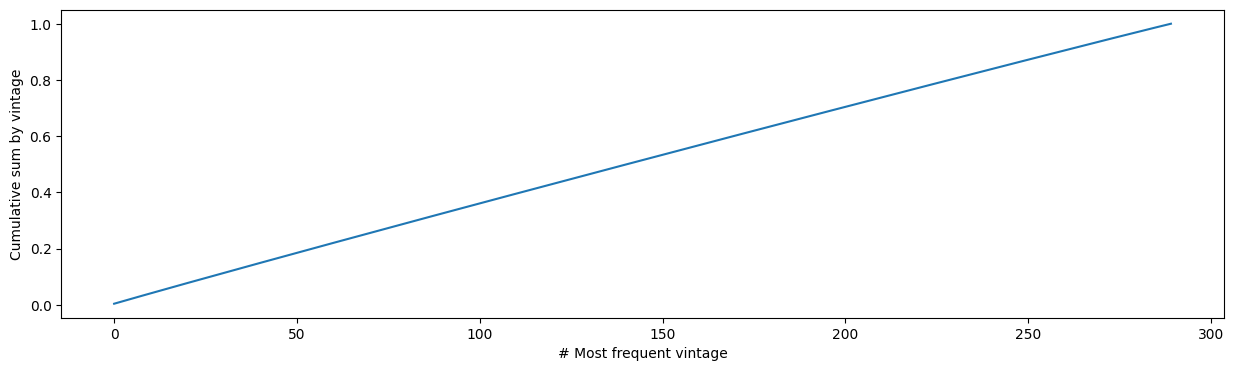

In [31]:
frequency_vintage = train_df["Vintage"].value_counts(normalize=True)

cumulative_vintage = np.cumsum(frequency_vintage)
index = np.arange(len(cumulative_vintage))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=cumulative_vintage, ax=ax)

ax.set_xlabel("# Most frequent vintage")
ax.set_ylabel("Cumulative sum by vintage")

plt.show()

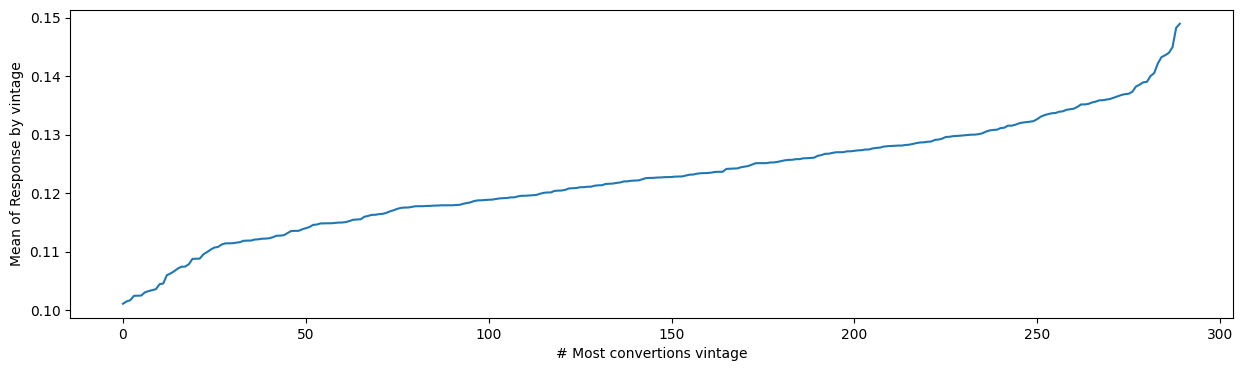

In [32]:
mean_response_by_vintage = train_df.groupby("Vintage")["Response"].mean().sort_values()

mean_response_by_vintage_values = mean_response_by_vintage.values
index = np.arange(len(mean_response_by_vintage))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=mean_response_by_vintage_values, ax=ax)

ax.set_xlabel("# Most convertions vintage")
ax.set_ylabel("Mean of Response by vintage")

plt.show()

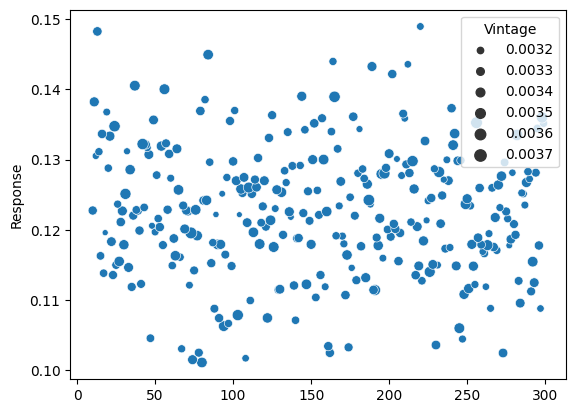

In [33]:
mean_response_and_frequency_by_vintage = pd.merge(mean_response_by_vintage, frequency_vintage, left_index=True, right_index=True)

sns.scatterplot(x=mean_response_and_frequency_by_vintage.index, y="Response", size="Vintage", data=mean_response_and_frequency_by_vintage)

plt.show()

In [34]:
test_categorical_independece(variables="Vintage", response="Response", data=train_df)

p_value of 0.9825945874525271, distributions independent


### Analyse region code

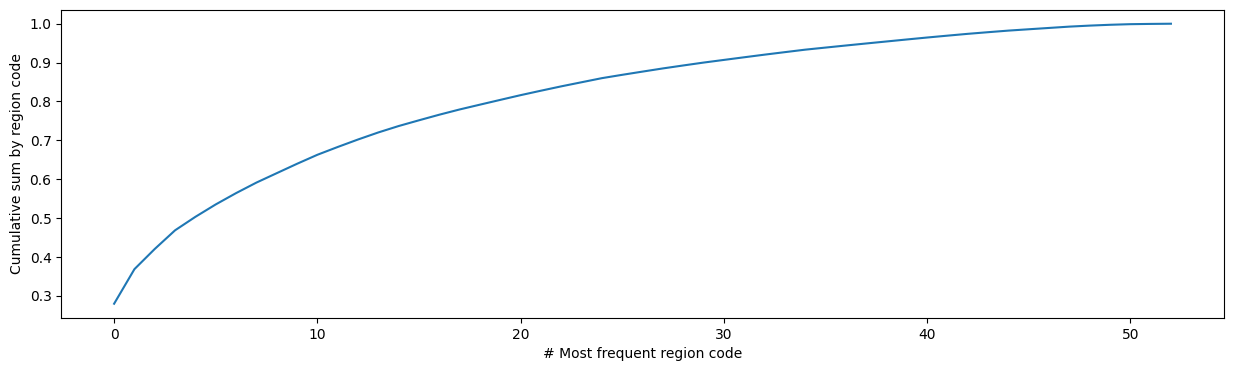

In [35]:
frequency_region_code = train_df["Region_Code"].value_counts(normalize=True)

cumulative_frequency_region_code = np.cumsum(frequency_region_code)
index = np.arange(len(frequency_region_code))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=cumulative_frequency_region_code, ax=ax)

ax.set_xlabel("# Most frequent region code")
ax.set_ylabel("Cumulative sum by region code")

plt.show()

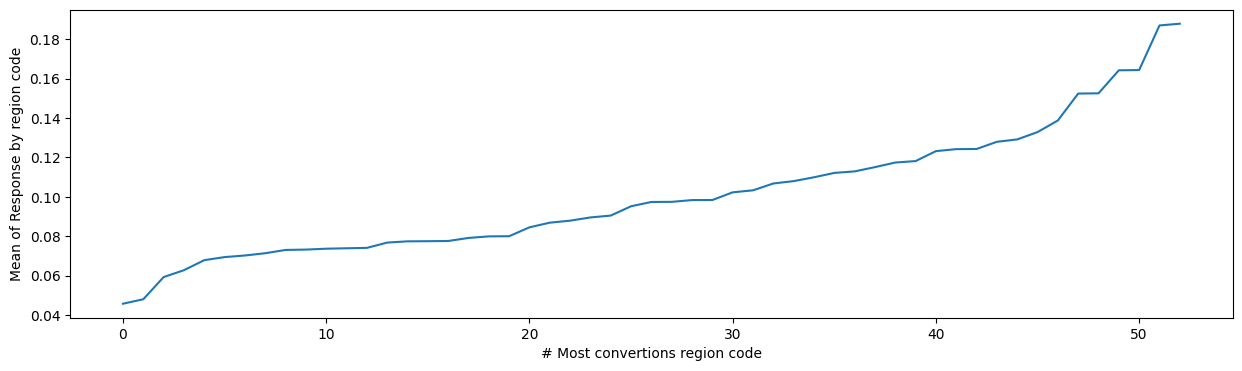

In [36]:
mean_response_by_region_code = train_df.groupby("Region_Code")["Response"].mean().sort_values()

mean_response_by_region_code.name="mean_response_by_region_code"

mean_response_by_region_code_values = mean_response_by_region_code.values
index = np.arange(len(mean_response_by_region_code))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=mean_response_by_region_code_values, ax=ax)

ax.set_xlabel("# Most convertions region code")
ax.set_ylabel("Mean of Response by region code")

plt.show()

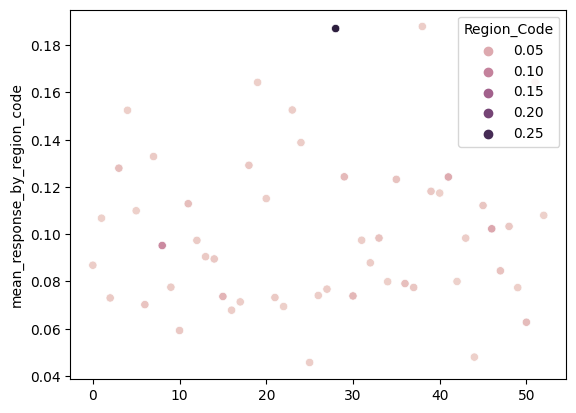

In [37]:
mean_response_and_frequency_by_region_code = pd.merge(mean_response_by_region_code, frequency_region_code, left_index=True, right_index=True)

sns.scatterplot(x=mean_response_and_frequency_by_region_code.index, y="mean_response_by_region_code", hue="Region_Code", data=mean_response_and_frequency_by_region_code)

plt.show()

In [38]:
test_categorical_independece(variables="Region_Code", response="Response", data=train_df)

p_value of 0.0, distributions are dependent


In [39]:
most_frequent_region_code = cumulative_frequency_region_code[cumulative_frequency_region_code < 0.9].index

## Draw relation between variables

### Age and vehicle damage

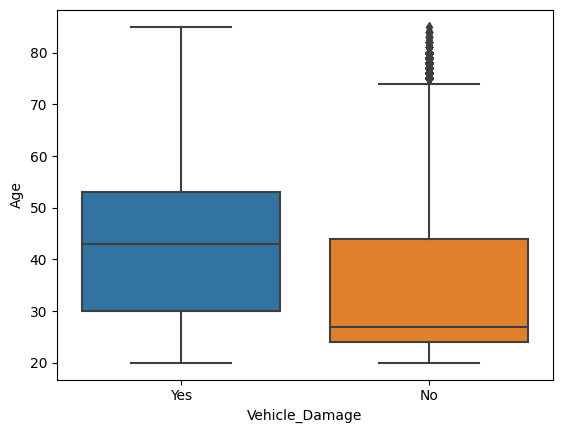

In [40]:
sns.boxplot(x="Vehicle_Damage", y="Age", data=train_df)
plt.show()

In [41]:
no_damage_age= train_df.query("Vehicle_Damage=='No'")["Age"]
damage_age = train_df.query("Vehicle_Damage=='Yes'")["Age"]

_, p_value = ttest_ind(no_damage_age, damage_age, equal_var=False, random_state=42, permutations=100)

alpha = 0.05

if p_value < alpha:
    print(f"p_value of {p_value}, distributions don't have equal means")
else:
    print(f"p_value of {p_value}, can't say if distributions have different means")

p_value of 0.0, distributions don't have equal means


### Age and gender

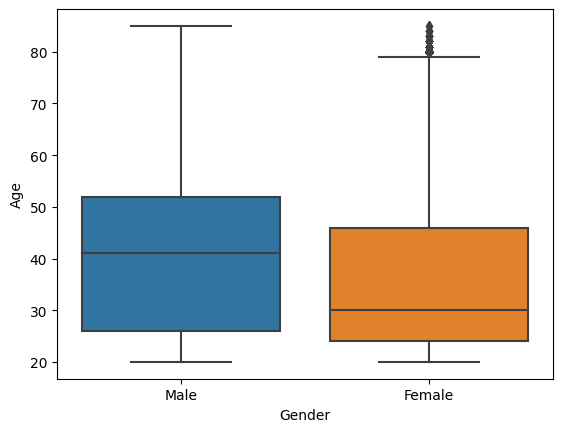

In [42]:
sns.boxplot(x="Gender", y="Age", data=train_df)
plt.show()

In [43]:
no_damage_age= train_df.query("Gender=='Male'")["Age"]
damage_age = train_df.query("Gender=='Female'")["Age"]

_, p_value = ttest_ind(no_damage_age, damage_age, equal_var=False, random_state=42, permutations=100)

alpha = 0.05

if p_value < alpha:
    print(f"p_value of {p_value}, distributions don't have equal means")
else:
    print(f"p_value of {p_value}, can't say if distributions have different means")

p_value of 0.0, distributions don't have equal means


### Age and premium

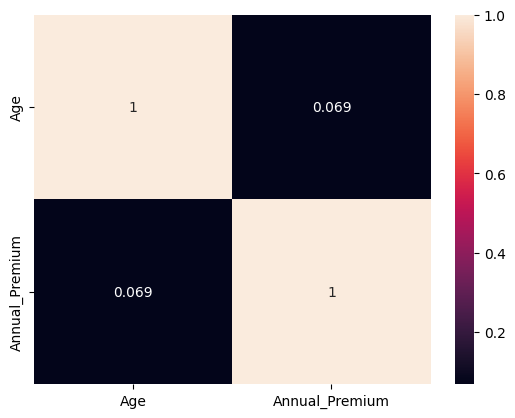

In [46]:
age_premium_correlation = train_df[["Age", "Annual_Premium"]].corr()

sns.heatmap(age_premium_correlation, annot=True)
plt.show()

### Gender and vehicle damage

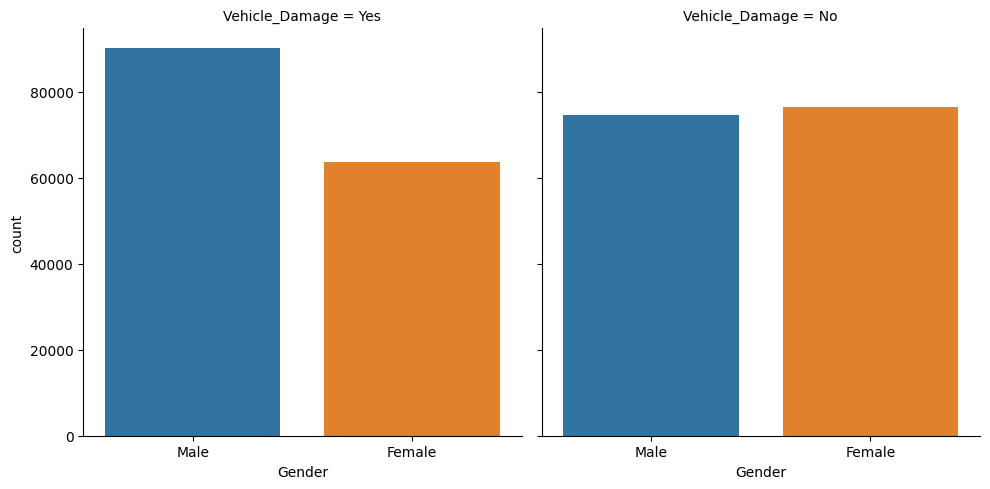

In [44]:
sns.catplot(x="Gender", col="Vehicle_Damage", data=train_df, kind="count")
plt.show()

In [45]:
test_categorical_independece(variables="Gender", response="Vehicle_Damage", data=train_df)

p_value of 0.0, distributions are dependent


### Vehicle age and premium

In [47]:
less_one_year_premium = train_df.query("Vehicle_Age=='< 1 Year'")["Annual_Premium"]
one_two_year_premium = train_df.query("Vehicle_Age=='1-2 Year'")["Annual_Premium"]
more_two_year_premium = train_df.query("Vehicle_Age=='> 2 Years'")["Annual_Premium"]

In [48]:
print(np.var(less_one_year_premium))
print(np.var(one_two_year_premium))
print(np.var(more_two_year_premium))

223003677.89615294
346471718.5069917
414875703.710784


In [49]:
_, p_value = levene(less_one_year_premium, one_two_year_premium, more_two_year_premium)

if p_value < 0.05:
    print(f"p value of {p_value}, variables do not have equal variance")
else:
    print(f"p value of {p_value}, variables have equal variance")

p value of 0.0, variables do not have equal variance


In [50]:
_, p_value = anova_oneway((less_one_year_premium, one_two_year_premium, more_two_year_premium), use_var="unequal")

if p_value < 0.05:
    print(f"p value {p_value:.3f}, premium is not equal between vehicle age")
else:
    print(f"p value {p_value:.3f}, premium is equal between vehicle age")

p value 0.000, premium is not equal between vehicle age


### Vehicle age and damage

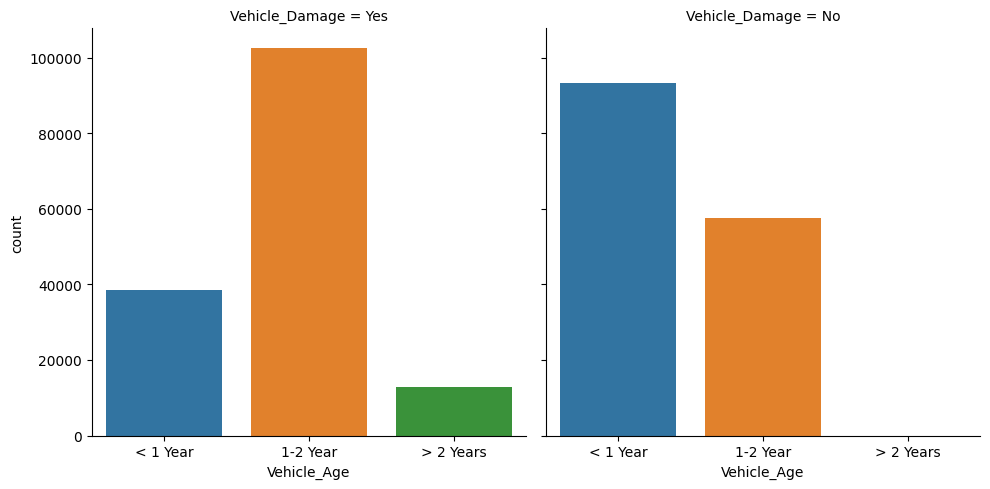

In [51]:
sns.catplot(x="Vehicle_Age", col="Vehicle_Damage", data=train_df, kind="count")
plt.show()

In [52]:
test_categorical_independece(variables="Vehicle_Age", response="Vehicle_Damage", data=train_df)

p_value of 0.0, distributions are dependent


### Vehicle age and gender

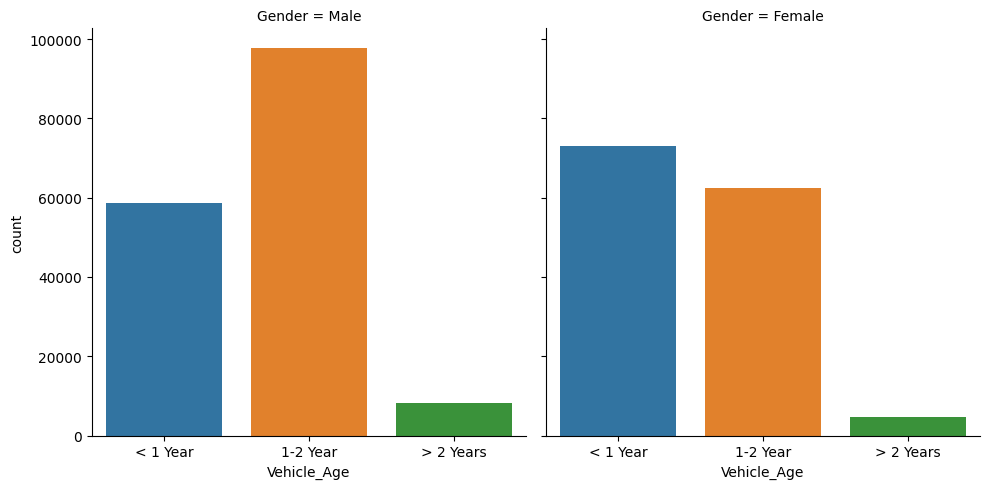

In [53]:
sns.catplot(x="Vehicle_Age", col="Gender", data=train_df, kind="count")
plt.show()

In [54]:
test_categorical_independece(variables="Vehicle_Age", response="Gender", data=train_df)

p_value of 0.0, distributions are dependent


### Vehicle age and age

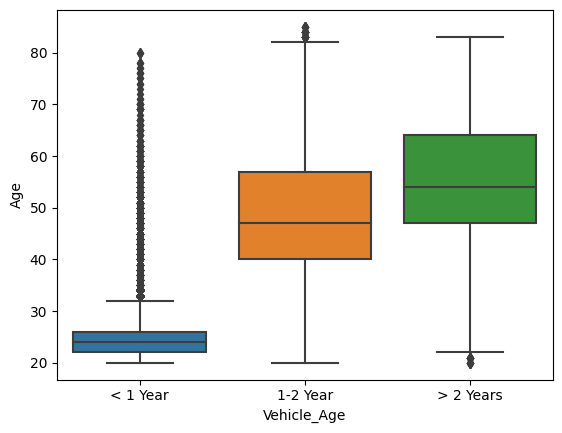

In [55]:
sns.boxplot(x="Vehicle_Age", y="Age", data=train_df)
plt.show()

In [56]:
less_one_year_age = train_df.query("Vehicle_Age=='< 1 Year'")["Age"]
one_two_year_age = train_df.query("Vehicle_Age=='1-2 Year'")["Age"]
more_two_year_age = train_df.query("Vehicle_Age=='> 2 Years'")["Age"]

In [57]:
print(np.var(less_one_year_age))
print(np.var(one_two_year_age))
print(np.var(more_two_year_age))

12.59032739194944
150.4963899290313
124.84129879732339


In [58]:
_, p_value = levene(less_one_year_age, one_two_year_age, more_two_year_age)

if p_value < 0.05:
    print(f"p value of {p_value}, variables do not have equal variance")
else:
    print(f"p value of {p_value}, variables have equal variance")

p value of 0.0, variables do not have equal variance


In [59]:
_, p_value = anova_oneway((less_one_year_age, one_two_year_age, more_two_year_age), use_var="unequal")

if p_value < 0.05:
    print(f"p value {p_value:.3f}, age is not equal between vehicle age")
else:
    print(f"p value {p_value:.3f}, age is equal between vehicle age")

p value 0.000, age is not equal between vehicle age


### Region code and sales channel

In [60]:
test_categorical_independece(variables="Region_Code", response="Policy_Sales_Channel", data=train_df, correction=True)

p_value of 0.0, distributions are dependent


### Region code and premium

In [61]:
region_codes = train_df["Region_Code"].unique()

premiuns_for_region = []
for region_code in region_codes[:2]:
    premium_in_region = train_df[train_df["Region_Code"] == region_code]["Annual_Premium"].values

    premiuns_for_region.append(premium_in_region)

In [62]:
_, p_value = levene(*premiuns_for_region)

if p_value < 0.05:
    print(f"p value of {p_value}, variables do not have equal variance")
else:
    print(f"p value of {p_value}, variables have equal variance")

p value of 0.009935731330781322, variables do not have equal variance


In [63]:
unpacked_values = (value for value in premiuns_for_region)

_, p_value = anova_oneway(unpacked_values, use_var="unequal")

if p_value < 0.05:
    print(f"p value {p_value:.3f}, premium is not equal between region codes")
else:
    print(f"p value {p_value:.3f}, premium is equal between region codes")

p value 0.000, premium is not equal between region codes


# Model Development

## Baseline model

In [64]:
class randomGuesser():
    balance_classes = 0.5

    def __init__(self, class_weight="uniform", random_seed=42):
        self.class_weight = class_weight
        self.random_seed = random_seed

    def fit(self, X, y):
        if self.class_weight == "balanced":
            value, counts = np.unique(y, return_counts=True)
            self.balance_classes = counts[1] / sum(counts)

    def predict(self, X):
        rng = np.random.default_rng(self.random_seed)

        prediction_size = len(X)
        
        predictions = rng.choice(2, size=prediction_size, p=[1-self.balance_classes, self.balance_classes])

        return predictions

In [65]:
y_train = train_df["Response"].values
y_val = val_df["Response"].values

X_train_baseline = train_df.values
X_val_baseline = val_df.values

In [66]:
random_guesser = randomGuesser()

random_guesser.fit(X_train_baseline, y_train)

random_guesser_train_predictions = random_guesser.predict(X_train_baseline)
random_guesser_val_predictions = random_guesser.predict(X_val_baseline)

In [67]:
print(classification_report(y_train, random_guesser_train_predictions))

              precision    recall  f1-score   support

           0       0.88      0.50      0.64    267519
           1       0.12      0.50      0.20     37368

    accuracy                           0.50    304887
   macro avg       0.50      0.50      0.42    304887
weighted avg       0.78      0.50      0.58    304887



In [68]:
def plot_confusion_matrix(labels, predictions, label_names=None):
    cm = confusion_matrix(labels, predictions)

    if label_names is None:
        label_names = np.unique(labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

    disp.plot()
    plt.show()

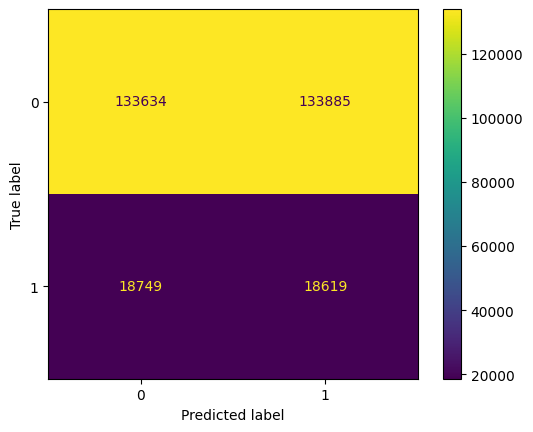

In [69]:
plot_confusion_matrix(y_train, random_guesser_train_predictions)

In [70]:
print(classification_report(y_val, random_guesser_val_predictions))

              precision    recall  f1-score   support

           0       0.88      0.50      0.63     66880
           1       0.12      0.50      0.20      9342

    accuracy                           0.50     76222
   macro avg       0.50      0.50      0.42     76222
weighted avg       0.78      0.50      0.58     76222



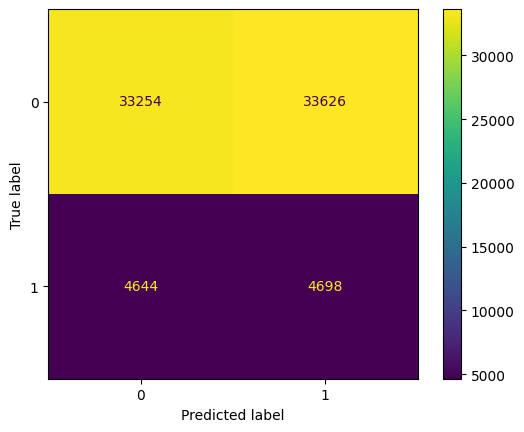

In [71]:
plot_confusion_matrix(y_val, random_guesser_val_predictions)

In [72]:
random_guesser_balanced = randomGuesser(class_weight="balanced")

random_guesser_balanced.fit(X_train_baseline, y_train)

random_guesser_balanced_train_predictions = random_guesser_balanced.predict(X_train_baseline)
random_guesser_balanced_val_predictions = random_guesser.predict(X_val_baseline)

In [73]:
print(classification_report(y_train, random_guesser_balanced_train_predictions))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88    267519
           1       0.12      0.12      0.12     37368

    accuracy                           0.79    304887
   macro avg       0.50      0.50      0.50    304887
weighted avg       0.78      0.79      0.78    304887



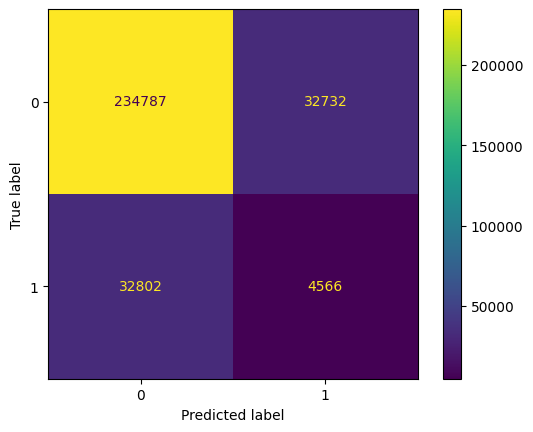

In [74]:
plot_confusion_matrix(y_train, random_guesser_balanced_train_predictions)

In [75]:
print(classification_report(y_val, random_guesser_balanced_val_predictions))

              precision    recall  f1-score   support

           0       0.88      0.50      0.63     66880
           1       0.12      0.50      0.20      9342

    accuracy                           0.50     76222
   macro avg       0.50      0.50      0.42     76222
weighted avg       0.78      0.50      0.58     76222



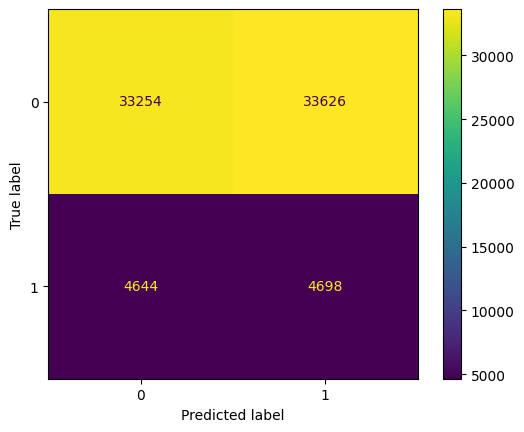

In [76]:
plot_confusion_matrix(y_val, random_guesser_balanced_val_predictions)

## Engineer features

In [77]:
def compute_frequencies(dataframe, categories, dataframe_to_compute_statistics):
    result_dataframe = dataframe.copy()

    for category in categories:
        frequencies = dataframe_to_compute_statistics[category].value_counts(normalize=True)
        frequencies.name = f"Frequencies_{category}"

        list_categories = dataframe[category]

        frequency_by_category = pd.merge(list_categories, frequencies, left_on=category, right_index=True )

        result_dataframe[f"Frequencies_{category}"] = frequency_by_category[f"Frequencies_{category}"]
        
    return result_dataframe

In [78]:
def compute_mean_response(dataframe, categories, dataframe_to_compute_statistics):
    result_dataframe = dataframe.copy()

    for category in categories:
        mean_response = dataframe_to_compute_statistics.groupby(category)["Response"].mean()
        mean_response.name = f"Mean_Response_{category}"

        list_categories = dataframe[category]

        mean_response_by_category = pd.merge(list_categories, mean_response, left_on=category, right_index=True )

        result_dataframe[f"Mean_Response_{category}"] = mean_response_by_category[f"Mean_Response_{category}"]
        
    return result_dataframe

In [79]:
def covalence_categories(dataframe, categories, dataframe_to_compute_statistics):
    result_dataframe = dataframe.copy()

    for category in categories:
        frequencies = dataframe_to_compute_statistics[category].value_counts(normalize=True)
        cumulative_frequencies = np.cumsum(frequencies)

        most_frequent = frequencies[cumulative_frequencies < 0.9].index

        is_most_frequent = dataframe[category].isin(most_frequent)

        result_dataframe[f"Is_Frequent_{category}"] = dataframe[category].loc[is_most_frequent]

    return result_dataframe

In [80]:
categories_to_covalence = ["Driving_License", "Policy_Sales_Channel", "Region_Code", "Vehicle_Damage", "Vehicle_Age", "Previously_Insured", "Gender"]


train_df_engineered = compute_frequencies(train_df, categories_to_covalence, train_df)
val_df_engineered = compute_frequencies(val_df, categories_to_covalence, train_df)

train_df_engineered = compute_mean_response(train_df_engineered, categories_to_covalence, train_df)
val_df_engineered = compute_mean_response(val_df_engineered, categories_to_covalence, train_df)

train_df_engineered = covalence_categories(train_df_engineered, categories_to_covalence, train_df)
val_df_engineered = covalence_categories(val_df_engineered, categories_to_covalence, train_df)

In [81]:
train_df_engineered = train_df_engineered.fillna(0)
val_df_engineered = val_df_engineered.fillna(0)

## Train models

In [82]:
feature_columns = ["Annual_Premium", "Frequencies_Driving_License", "Mean_Response_Driving_License",
                    "Frequencies_Policy_Sales_Channel", "Mean_Response_Policy_Sales_Channel", 
                    "Frequencies_Vehicle_Damage", "Mean_Response_Vehicle_Damage",
                    "Frequencies_Vehicle_Age",  "Mean_Response_Vehicle_Age",
                    "Frequencies_Previously_Insured", "Mean_Response_Previously_Insured",
                    "Frequencies_Gender", "Mean_Response_Gender",
                    "Frequencies_Region_Code", "Mean_Response_Region_Code"]

y_train = train_df_engineered["Response"].values
features_df = train_df_engineered[feature_columns].copy()

In [83]:
X_train = features_df.values

In [84]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

### Prepare validation data

In [85]:
val_df_engineered["Response"].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: Response, dtype: float64

In [86]:
y_val = val_df_engineered["Response"].values

features_val = val_df_engineered[feature_columns].copy()

In [87]:
X_val = features_val.values

X_val_scaled = scaler.transform(X_val)

### Train logistic regression

In [88]:
logreg = LogisticRegression(class_weight="balanced")

logreg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [89]:
y_pred_logreg = logreg.predict(X_train_scaled)

print(classification_report(y_train, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79    267519
           1       0.28      0.93      0.43     37368

    accuracy                           0.69    304887
   macro avg       0.63      0.80      0.61    304887
weighted avg       0.90      0.69      0.75    304887



In [90]:
y_pred_logreg = logreg.predict(X_val_scaled)
y_proba_pred_logreg = logreg.predict_proba(X_val_scaled)[:,1]

print(classification_report(y_val, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79     66880
           1       0.28      0.93      0.43      9342

    accuracy                           0.70     76222
   macro avg       0.63      0.80      0.61     76222
weighted avg       0.90      0.70      0.75     76222



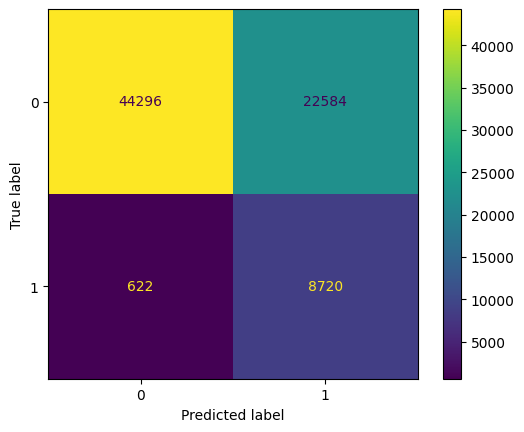

In [91]:
plot_confusion_matrix(y_val, y_pred_logreg)

In [92]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")


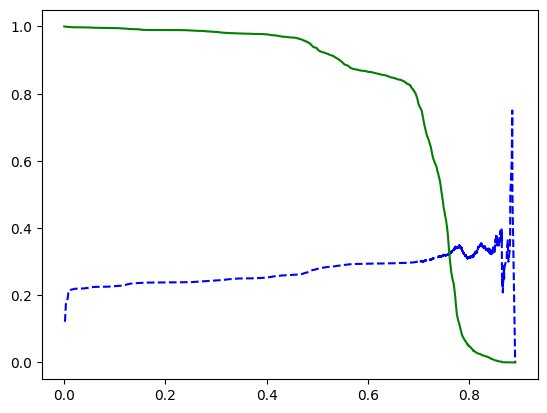

In [93]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba_pred_logreg)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### Train random forrest

In [94]:
forrest = RandomForestClassifier(class_weight="balanced", n_jobs=-1)

forrest.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [95]:
y_pred_forrest = forrest.predict(X_train_scaled)

print(classification_report(y_train, y_pred_forrest))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    267519
           1       0.68      0.98      0.80     37368

    accuracy                           0.94    304887
   macro avg       0.84      0.96      0.88    304887
weighted avg       0.96      0.94      0.95    304887



In [96]:
y_pred_forrest = forrest.predict(X_val_scaled)
y_proba_pred_forrest = forrest.predict_proba(X_val_scaled)[:,1]

print(classification_report(y_val, y_pred_forrest))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89     66880
           1       0.28      0.38      0.33      9342

    accuracy                           0.80     76222
   macro avg       0.60      0.62      0.61     76222
weighted avg       0.83      0.80      0.82     76222



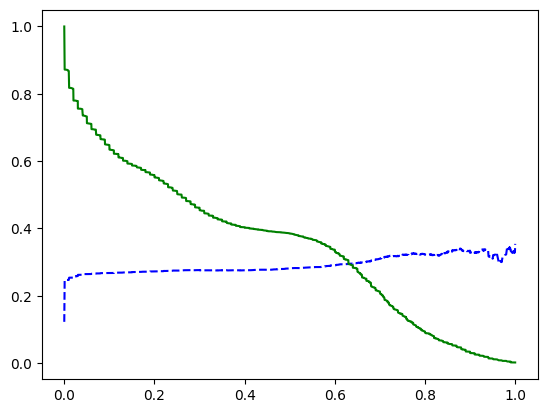

In [97]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba_pred_forrest)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### Train SVM

In [98]:
svm = SGDClassifier(class_weight="balanced", max_iter=3_000)

svm.fit(X_train_scaled, y_train)

SGDClassifier(class_weight='balanced', max_iter=3000)

In [99]:
y_pred_svm = svm.predict(X_train_scaled)

print(classification_report(y_train, y_pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74    267519
           1       0.25      0.98      0.40     37368

    accuracy                           0.64    304887
   macro avg       0.62      0.78      0.57    304887
weighted avg       0.90      0.64      0.70    304887



In [100]:
y_pred_svm = svm.predict(X_val_scaled)
y_proba_pred_svm = svm.decision_function(X_val_scaled)

print(classification_report(y_val, y_pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.98      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222



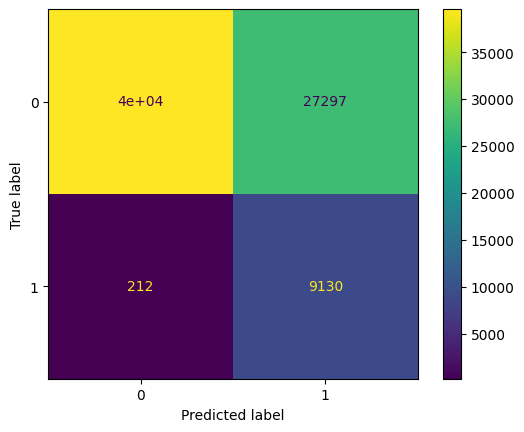

In [101]:
plot_confusion_matrix(y_val, y_pred_svm)

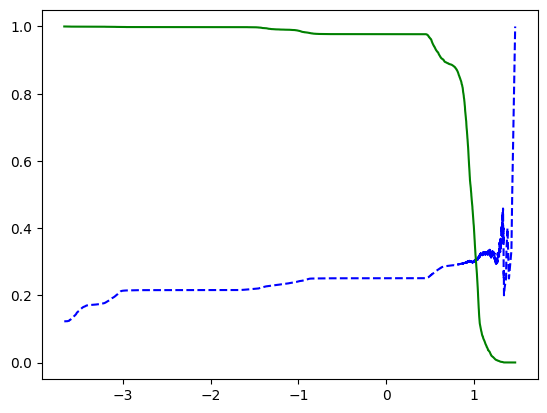

In [102]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba_pred_svm)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### Train KNN

In [103]:
knn = KNeighborsClassifier(n_jobs=-1)

knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_jobs=-1)

In [104]:
y_pred_knn = knn.predict(X_train_scaled)

print(classification_report(y_train, y_pred_knn))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94    267519
           1       0.62      0.30      0.40     37368

    accuracy                           0.89    304887
   macro avg       0.76      0.64      0.67    304887
weighted avg       0.87      0.89      0.87    304887



In [105]:
y_pred_knn = knn.predict(X_val_scaled)
y_pred_proba_knn = knn.predict_proba(X_val_scaled)[:, 1]

print(classification_report(y_val, y_pred_knn))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     66880
           1       0.32      0.15      0.21      9342

    accuracy                           0.86     76222
   macro avg       0.60      0.55      0.56     76222
weighted avg       0.82      0.86      0.83     76222



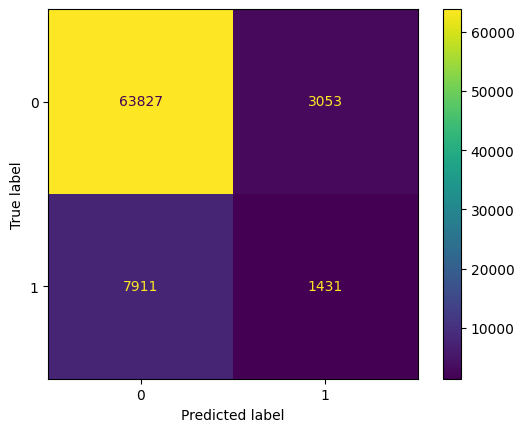

In [106]:
plot_confusion_matrix(y_val, y_pred_knn)

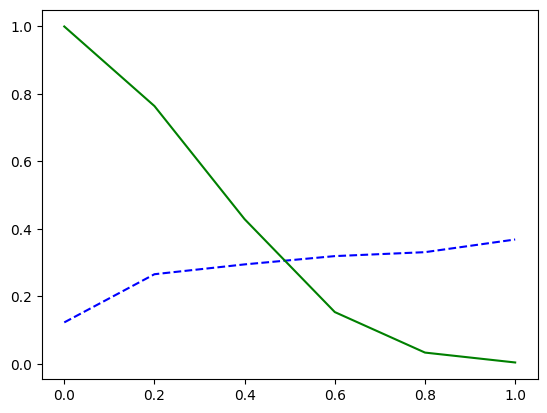

In [107]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba_knn)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### Bagging

#### Logistic regression

In [108]:
logistic_bagging = BaggingClassifier(base_estimator=LogisticRegression(class_weight="balanced"), n_estimators=40, n_jobs=-1)

logistic_bagging.fit(X_train_scaled, y_train)

y_pred_logistic_bagging = logistic_bagging.predict(X_train_scaled)

print(classification_report(y_train, y_pred_logistic_bagging))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79    267519
           1       0.28      0.93      0.43     37368

    accuracy                           0.69    304887
   macro avg       0.63      0.80      0.61    304887
weighted avg       0.90      0.69      0.75    304887



In [109]:
y_pred_logistic_bagging = logistic_bagging.predict(X_val_scaled)
y_pred_proba_logistic_bagging = logistic_bagging.predict_proba(X_val_scaled)[:, 1]


print(classification_report(y_val, y_pred_logistic_bagging))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79     66880
           1       0.28      0.93      0.43      9342

    accuracy                           0.70     76222
   macro avg       0.63      0.80      0.61     76222
weighted avg       0.90      0.70      0.75     76222



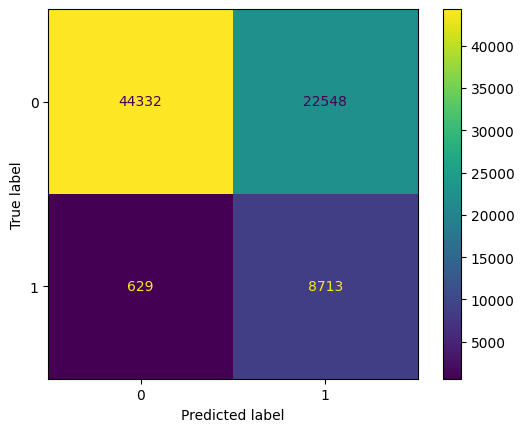

In [110]:
plot_confusion_matrix(y_val, y_pred_logistic_bagging)

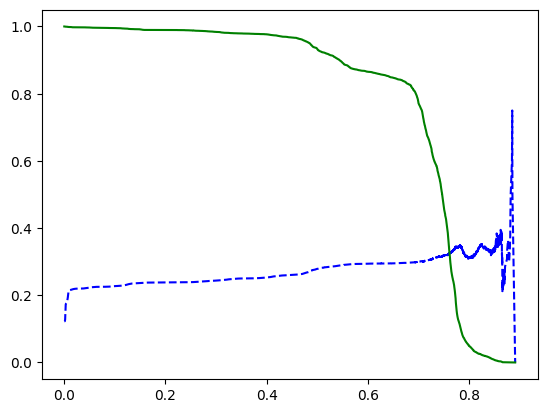

In [111]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba_logistic_bagging)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#### Decision Tree

In [112]:
tree_bagging = BaggingClassifier(n_estimators=10, n_jobs=-1)

tree_bagging.fit(X_train_scaled, y_train)

y_pred_tree_bagging = tree_bagging.predict(X_train_scaled)

print(classification_report(y_train, y_pred_tree_bagging))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    267519
           1       0.95      0.71      0.82     37368

    accuracy                           0.96    304887
   macro avg       0.96      0.85      0.90    304887
weighted avg       0.96      0.96      0.96    304887



In [113]:
y_pred_tree_bagging = tree_bagging.predict(X_val_scaled)
y_pred_proba_tree_bagging = tree_bagging.predict_proba(X_val_scaled)[:, 1]

print(classification_report(y_val, y_pred_tree_bagging))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     66880
           1       0.30      0.17      0.22      9342

    accuracy                           0.85     76222
   macro avg       0.60      0.56      0.57     76222
weighted avg       0.82      0.85      0.83     76222



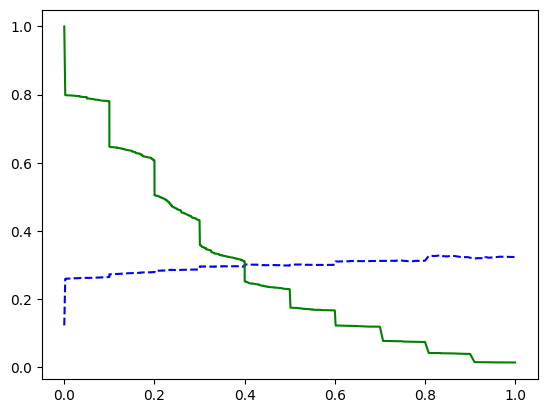

In [114]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba_tree_bagging)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

## Deal with imbalance using smote

In [115]:
over_sampler = SMOTE(sampling_strategy=0.2, n_jobs=-1, random_state=42)
under_sampler = RandomUnderSampler(sampling_strategy=0.5)

sampling_pipeline = Pipeline([("over sampler", over_sampler), ("under sampler", under_sampler)])

In [116]:
X_train_balanced, y_train_balanced = sampling_pipeline.fit_resample(X_train_scaled, y_train)

### Evaluate KNN

In [117]:
knn = KNeighborsClassifier(n_jobs=-1)

knn.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier(n_jobs=-1)

In [118]:
y_pred_knn = knn.predict(X_train_balanced)

print(classification_report(y_train_balanced, y_pred_knn))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87    107006
           1       0.74      0.69      0.72     53503

    accuracy                           0.82    160509
   macro avg       0.80      0.79      0.79    160509
weighted avg       0.81      0.82      0.82    160509



In [119]:
y_pred_knn = knn.predict(X_val_scaled)
y_pred_proba_knn = knn.predict_proba(X_val_scaled)[:, 1]


print(classification_report(y_val, y_pred_knn))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87     66880
           1       0.29      0.51      0.37      9342

    accuracy                           0.79     76222
   macro avg       0.61      0.67      0.62     76222
weighted avg       0.85      0.79      0.81     76222



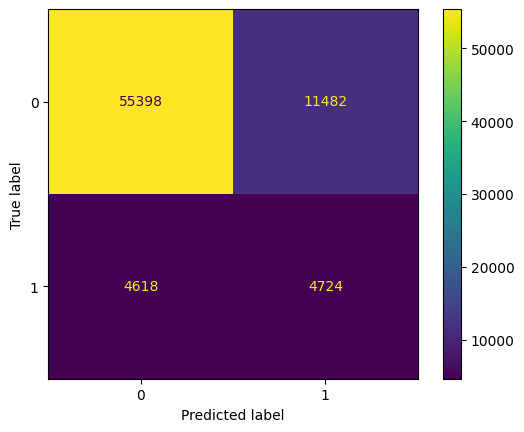

In [120]:
plot_confusion_matrix(y_val, y_pred_knn)

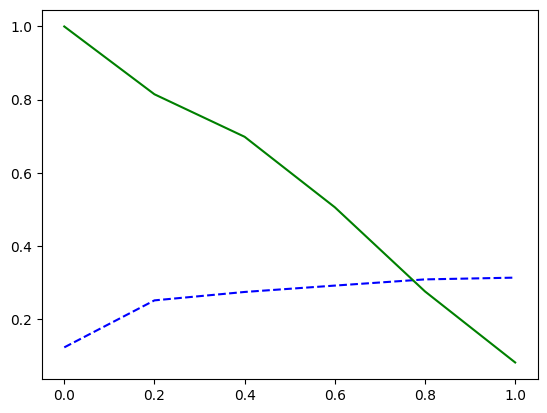

In [121]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba_knn)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### Evaluate random forrest

In [122]:
forrest = RandomForestClassifier(class_weight="balanced", n_jobs=-1)

forrest.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [123]:
y_pred_forrest = forrest.predict(X_train_balanced)

print(classification_report(y_train_balanced, y_pred_forrest))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96    107006
           1       0.89      0.99      0.93     53503

    accuracy                           0.95    160509
   macro avg       0.94      0.96      0.95    160509
weighted avg       0.96      0.95      0.95    160509



In [124]:
y_pred_forrest = forrest.predict(X_val_scaled)
y_pred_proba_forrest = forrest.predict_proba(X_val_scaled)[:, 1]

print(classification_report(y_val, y_pred_forrest))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85     66880
           1       0.28      0.58      0.38      9342

    accuracy                           0.76     76222
   macro avg       0.60      0.69      0.62     76222
weighted avg       0.85      0.76      0.80     76222



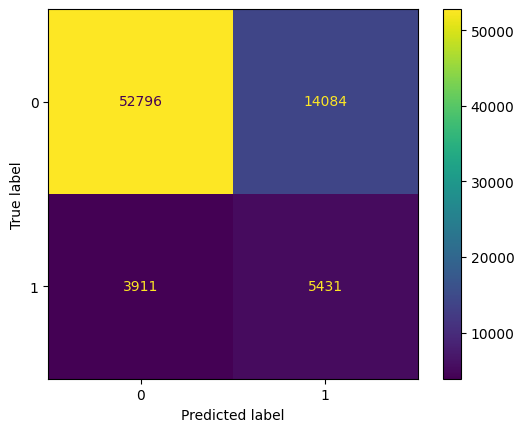

In [125]:
plot_confusion_matrix(y_val, y_pred_forrest)

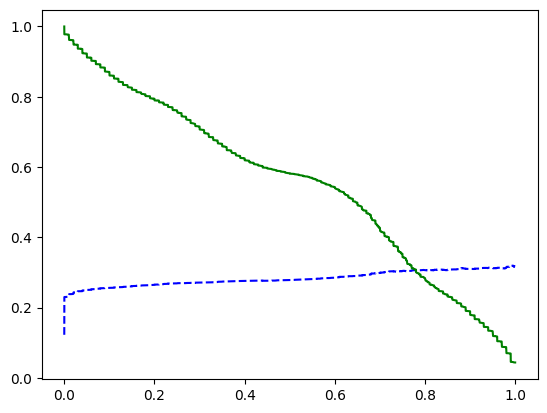

In [126]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba_forrest)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)